# Finding the period and time for a system, while introducing noise

In [ ]:
from sympy import symbols, Matrix,re
import numpy as np
import matplotlib
import imageio.v2 as imageio
from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sm
import os
from scipy.optimize import curve_fit
from scipy.spatial import cKDTree
from scipy.integrate import solve_ivp
plt.rcParams['figure.figsize'] = [12, 12]

#Selkov model for glycolysis
def SelkovX(x,y,b,a = 0.1):
    return -x + a*y + x**2*y

def SelkovY(x,y,b,a = 0.1):
    return b - a*y - x**2*y


#Supercritical hopf bifurcation
def x_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*x-w*y #normalformen for superkritiske hopf.
def y_supercrit(x,y,mu,w = 1):
    return (mu-x**2-y**2)*y+w*x

#Solutions to the supercritcal hopf bifurcation
def solution_supercrit_Pol(t,mu,w,r0): #Polar coordinates
    C = (r0**2-mu)/(r0**2)
    T = 2*mu*t
    return (mu/(1-C*np.exp(-T)))**0.5

def solution_supercrit_Cart(t, mu,w, x0, y0): #Cartesian coordinates
    return np.cos(w*t)*solution_supercrit_Pol(t, mu, w, x0), np.sin(w*t)*solution_supercrit_Pol(t, mu, w, y0) #x(t) and y(t)


#Van Der Pol

def VanX(x,y,mu,w):
    return y
def VanY(x,y,mu,w):
    return mu*(1-x**2)*y-x

#Other stuff
def linfit(x,a,b):
    return a*x+b
def quadfit(x,a,b,c):
    return a*x**2+b*x+c
def cubicfit(x,a,b,c,d):
    return a*x**3+b*x**2+c*x+d


In [ ]:
def intgrator_rk4(func_x,func_y,dt,x,y,paramsx,paramsy, D = 0): #Input function, timestep, coordinates and finally params as [...,...,...]
    
    k1x = func_x(x,y,*paramsx)*dt 
    k1y = func_y(x,y,*paramsy)*dt 

    k2x = func_x(x+0.5*k1x, y+0.5*k1y, *paramsx)*dt 
    k2y = func_y(x+0.5*k1x, y+0.5*k1y, *paramsy)*dt 
    
    k3x = func_x(x+0.5*k2x, y+0.5*k2y, *paramsx)*dt 
    k3y = func_y(x+0.5*k2x, y+0.5*k2y, *paramsy)*dt 
    
    k4x = func_x(x+k3x,y+k3y, *paramsx)*dt 
    k4y = func_y(x+k3x,y+k3y, *paramsy)*dt 
    
    xnew = x + 1./6*(k1x+2*k2x+2*k3x+k4x) + np.sqrt(2*D)*dt*np.random.normal(0,1)
    ynew = y + 1./6*(k1y+2*k2y+2*k3y+k4y) + np.sqrt(2*D)*dt*np.random.normal(0,1) 

    return xnew, ynew
def supercrit_floquet(mu):
    return 2*mu #Floquet at LC

def VDP_floquet(mu):
    return mu #Floquet at LC

def eig_trajectory(point_amount,solution,functionx,functiony,params, lb = 1.01, ub = 1.0,noise_parameter = 0,distance_trad = False,plot = False,npoints = 50000, dt = 0.005): #Bevægelsesfunktionen
    #The function creates a list for the kdtree, takes some points evenly spaced a distance from the limit cycle, and then calculates the distance to the limit cycle for each trajectory
    Tlist = np.linspace(0,10*np.pi,npoints)
    traject_list = []
    mu = params[0]
    w = params[1]
    spacing_value = np.linspace(lb, ub, point_amount)
    limitx, limity = solution(Tlist,mu,1,np.sqrt(mu),np.sqrt(mu)) #Circle of points
    startlist = [(0, spacing * np.sqrt(abs(mu))) for spacing in spacing_value]
    if plot:
        fig, ax = plt.subplots()
        for r in startlist:
            x0,y0 = r
            sol_x, sol_y = np.zeros(npoints), np.zeros(npoints)
            sol_x[0], sol_y[0] = x0, y0
            for i in range(1, npoints):
                x0, y0 = intgrator_rk4(functionx, functiony, dt, x0, y0, [mu,w], [mu,w], D = noise_parameter)
                sol_x[i], sol_y[i] = x0, y0
            traject_list.append((sol_x,sol_y))
            # Plot the trajectory
            ax.plot(sol_x[0],sol_y[0], 'o', color='black')
            ax.plot(sol_x, sol_y, ls='-', color='blue',alpha = 0.2)
        ax.plot(sol_x, sol_y, ls='-', color='blue', label = "Trajectory", alpha = 0.2)
        ax.plot(startlist[0][0],startlist[0][1], 'o', color = 'black', label = "Initial point")
        ax.title.set_text(f'Trajectories with $\mu$ = {mu} ')
        ax.plot(limitx, limity, ls='-', color='red',  label = "Limit cycle")
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.legend()
        plt.show()
    else:
        for r in startlist:
            x0,y0 = r
            sol_x, sol_y = np.zeros(npoints), np.zeros(npoints)
            sol_x[0], sol_y[0] = x0, y0
            for i in range(1, npoints):
                x0, y0 = intgrator_rk4(functionx, functiony, dt, x0, y0, [mu,w], [mu,w], D = noise_parameter)
                sol_x[i], sol_y[i] = x0, y0
            traject_list.append((sol_x,sol_y))
    return traject_list, limitx,limity

def calculate_distance_to_limit_cycle(trajectory, limit_cycle_x, limit_cycle_y):
    # Create a KDTree for limit cycle points, speeds up instead of using values directly.
    limit_cycle_points = np.vstack((limit_cycle_x, limit_cycle_y)).T
    kdtree = cKDTree(limit_cycle_points)
    
    #distances = []
    trajectory_points = np.vstack((trajectory[0], trajectory[1])).T
    distances, _ = kdtree.query(trajectory_points)
    return distances

def distance_eig(point_amount,solution,functionx,functiony,params,lb = 1.01,ub = 1.05,noise_parameter = 0,plot = False,distance_trad = False, npoints = 50000, dt = 0.005): #Afstandsberegneren
    #This function calls the eig_trajectory functions, and then calculates the distance to the limit cycle for each trajectory while sorting the floquet exponents and distances
    #Main differenece between distance_trad and the poincaré slice is that the poincare slice is much much faster even with more points (and lower timesteps) while being able to handle way more points.
    traject_list,limx,limy = eig_trajectory(point_amount = point_amount,solution = solution,functionx = functionx,functiony = functiony,params = params,noise_parameter = noise_parameter, lb=lb,ub=ub,distance_trad=distance_trad,plot = plot, npoints = npoints, dt = dt)
    if distance_trad:
        time_spent = npoints*dt
        timespace = np.linspace(0,time_spent,npoints)
    dist0list = np.array([])
    for sol_x, sol_y in traject_list:
        #if distance_trad:
        distances = calculate_distance_to_limit_cycle((sol_x, sol_y), limx, limy)
        #else: 
        #    timespace,distances = poincare_slice(sol_x, sol_y, limx, limy,functionx=functionx,mu=params[0],npoints=npoints,dt=dt)
        #dist0list= np.append(dist0list,distances[0])
    for idx,r in enumerate(distances):
        if np.isclose(r,0,atol = 10e-6): #Optimize, argmin?
            return idx 

dt = 0.1
mulist = np.linspace(0.1,0.5,1)
floquet_vals = -supercrit_floquet(mulist)
time_list = np.zeros_like(mulist)
noiselist =[0,10e-8,10e-7,10e-6]#np.arange(0,10e-7,4*10e-8)# np.linspace(0,10e-6,3)
for noise in noiselist:
    for j,mu in enumerate(mulist):
        idx=distance_eig(1,solution_supercrit_Cart,x_supercrit,y_supercrit,[mu,1],lb=1.05,ub=1.1,plot = False,noise_parameter = noise,npoints=80000,dt=dt)
        time_list[j] = idx
    plt.plot(mulist,time_list*dt,'-', label = f'noise = {noise}')
plt.ylabel('Time',fontsize = 20)
plt.xlabel('$\mu$',fontsize = 20)
plt.title(f'Time before reaching LC as a function of $\mu$ from same distance' ,fontsize = 20)
plt.legend(fontsize = 15)
plt.xticks(fontsize=11) 
plt.yticks(fontsize=11)


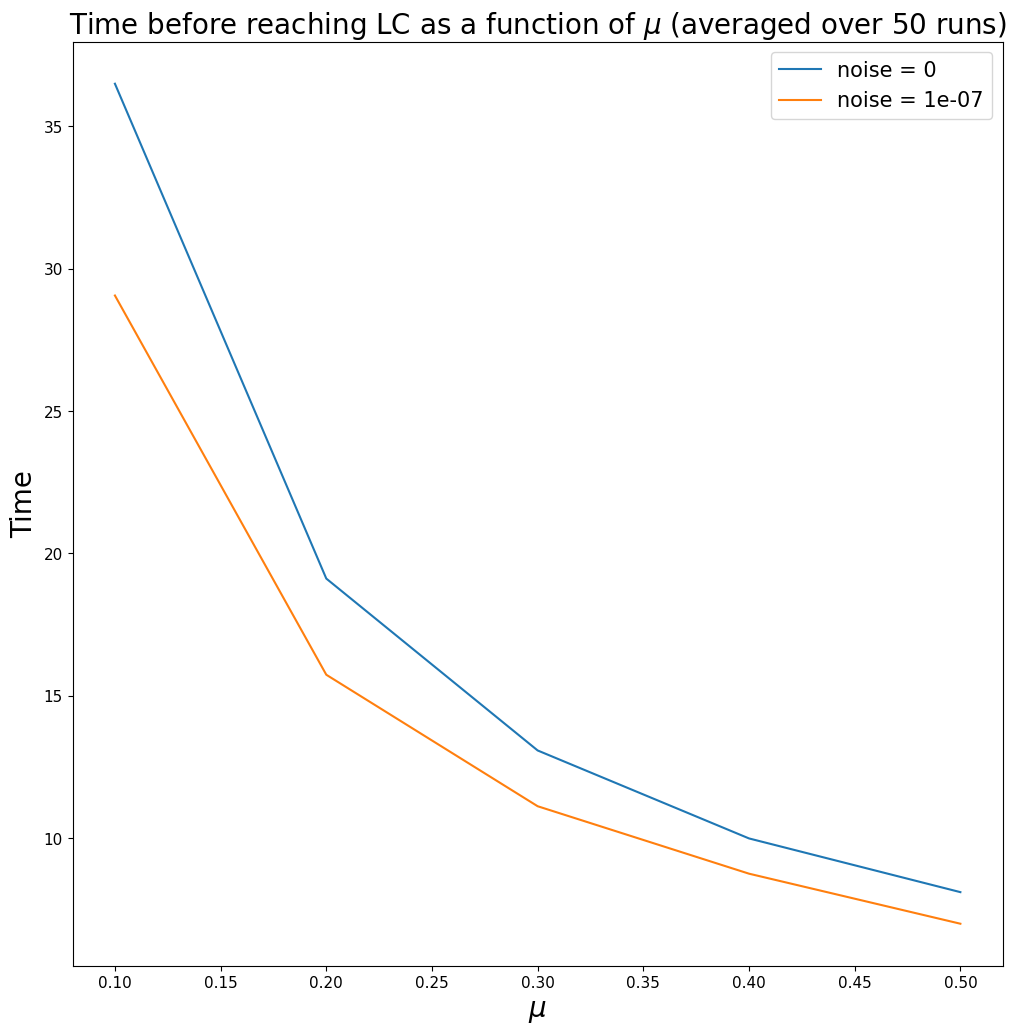

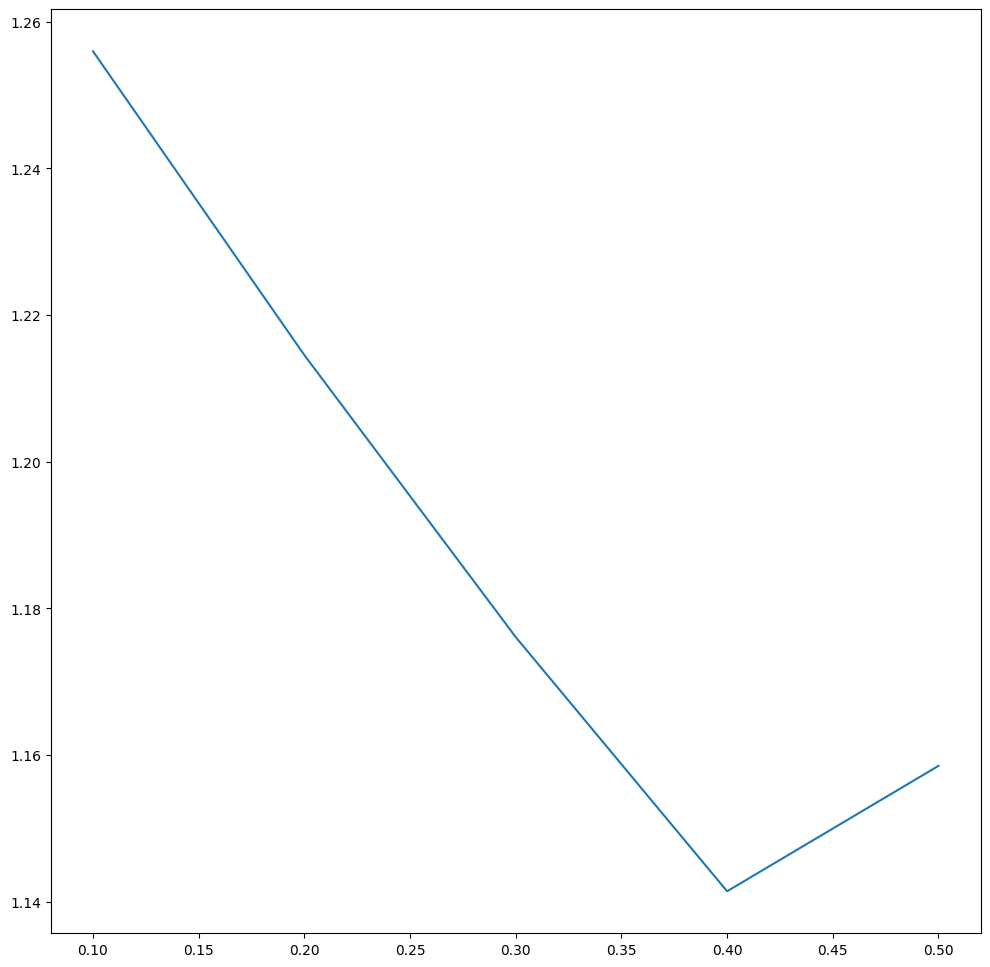

In [31]:
mulist = np.linspace(0.1, 0.5, 5)
floquet_vals = -supercrit_floquet(mulist)
noiselist = [0, 10e-8]#, 10e-7, 10e-6]
n_runs = 50  # Number of runs for averaging
dt = 0.001  # Define your time step, adjust as needed
#Placeholde to store the averaged results
time_mean_list = np.zeros_like(mulist)
c = []
# Loop over each noise value
for noise in noiselist:
    # Reset the list for each noise level
    time_accumulated = np.zeros_like(mulist)
    if noise == 0:
        time_list = np.zeros_like(mulist)
        for j, mu in enumerate(mulist):
            idx = distance_eig(1, solution_supercrit_Cart, x_supercrit, y_supercrit, [mu, 1], 
                               lb=1.05, ub=1.1, plot=False, noise_parameter=noise, 
                               npoints=50000, dt=dt)
            time_list[j] = idx
        plt.plot(mulist, time_list * dt, '-', label=f'noise = {noise}')
        c.append(time_list*dt)
    else:
    # Repeat the process n_runs times to compute the mean
        for _ in range(n_runs):
            time_list = np.zeros_like(mulist)  # Temporary list for each run
            
            # Loop over each mu value
            for j, mu in enumerate(mulist):
                # Call the function distance_eig and store the result
                idx = distance_eig(1, solution_supercrit_Cart, x_supercrit, y_supercrit, [mu, 1], 
                                lb=1.02, ub=1.1, plot=False, noise_parameter=noise, 
                                npoints=50000, dt=dt)
                time_list[j] = idx

            # Accumulate the results to compute the average after the loop
            time_accumulated += time_list
    
    # Compute the mean for each mu value over n_runs
        time_mean_list = time_accumulated / n_runs
        c.append(time_mean_list*dt)
    # Plot the averaged curve for this noise value
        plt.plot(mulist, time_mean_list * dt, '-', label=f'noise = {noise}')

# Add labels and legend
plt.ylabel('Time', fontsize=20)
plt.xlabel('$\mu$', fontsize=20)
plt.title(f'Time before reaching LC as a function of $\mu$ (averaged over {n_runs} runs)', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show the plot
plt.show()
plt.plot(mulist,c[0]/c[1],label = f'Ratio of no noise over {noiselist[1]}')
#plt.plot(mulist,c[0]/c[2], label = f"Ratio of no_noise over {noiselist[2]}")

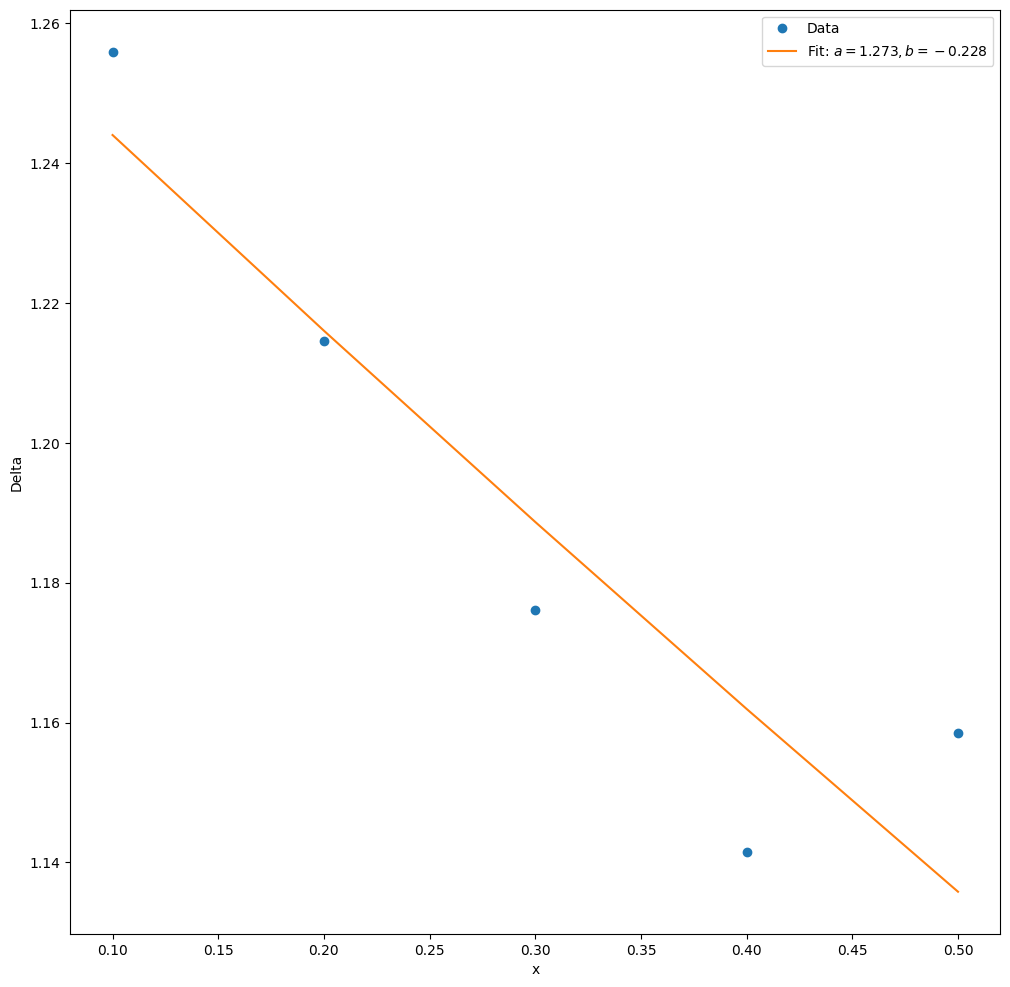

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming mulist, c[0], and c[1] are already defined
delta = c[0]/ c[1]

# Define the exponential function
def exp_fit(x, a, b):
    return a * np.exp(b * x)

# Fit the curve
popt, pcov = curve_fit(exp_fit, mulist, delta)

# Extract the parameters
a, b = popt

# Generate fitted values
fitted_delta = exp_fit(np.array(mulist), a, b)

# Plot the original data and the fitted curve
plt.plot(mulist, delta, 'o', label="Data")
plt.plot(mulist, fitted_delta, '-', label=f"Fit: $a={a:.3f}, b={b:.3f}$")
plt.xlabel("x")
plt.ylabel("Delta")
plt.legend()
plt.show()


In [ ]:
plt.plot(mulist,c[0]-c[1],label = 'ratio')


In [ ]:
def LC_coords(xmap,ymap,functionx,functiony,params,runtime,converging_time,dt,dt_conv,noise = 0):
        time_converg = 0
        time_data = 0
        mu,w = params
        running = True
        listsize = int(runtime / dt)
        limitx = np.zeros(listsize*5)
        limity = np.zeros(listsize*5)
        index = 0
        dtr = dt_conv
        while running:
            xmap, ymap = intgrator_rk4(functionx, functiony, dtr, xmap, ymap, [mu,w], [mu,w], D = noise)
            if time_converg < converging_time:
                time_converg += dtr
            else:
                dtr = dt
                time_data += dtr
                limitx[index] = xmap
                limity[index] = ymap
                index +=1
                if time_data > runtime:
                    running = False
        limitx,limity = np.array(limitx),np.array(limity)
        return limitx[:index],limity[:index]

dt = 0.001
#mu = 0.1
w = 1
mulist = [1]#np.linspace(0.2,1,50)
def numerical_jacobian(limitx,limity, dt):
    jacobian = []
    trace = []
    determinant = []
    for k in range(1,len(limitx)-1):
        dx = limitx[k+1]-limitx[k]
        dy = limity[k+1]-limity[k]
        dXdx = (limitx[k+1]-2*limitx[k]+limitx[k-1])/(dx*dt)
        dXdy = (limitx[k+1]-2*limitx[k]+limitx[k-1])/(dy*dt)

        dYdx = (limity[k+1]-2*limity[k]+limity[k-1])/(dx*dt)
        dYdy = (limity[k+1]-2*limity[k]+limity[k-1])/(dy*dt)
        jacobian.append(np.array([[dXdx,dXdy],[dYdx,dYdy]]))
    num_jac=np.mean((jacobian),axis = 0)
    trace.append(np.trace(num_jac))
    determinant.append(np.linalg.det(num_jac))
    return num_jac,trace,determinant
mulist = [0.001]
tracelist = []
determinantlist = []
for mu in mulist:
    #limitx,limity = LC_coords(2,0,VanX,VanY,[mu,w],runtime=10*np.pi,converging_time=1,dt_conv = 0.005,dt = dt,noise = 0) #Giver bare koordinaterne for LC
    limitx,limity = LC_coords(2,0,VanX,VanY,[mu,w],runtime=20*np.pi,converging_time=5,dt_conv = 0.005,dt = dt,noise = 0) #Giver bare koordinaterne for LC
    numjac,trace,deter = numerical_jacobian(limitx,limity, dt)
    tracelist.append(trace)
    determinantlist.append(deter)
    #plt.plot(limitx,limity)
print(numjac)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10)) 
plt.title('Numerical Jacobian') 

ax[0].plot(mulist, tracelist, '.', label='Trace')
ax[0].plot(mulist, 2*mulist, '-', label='Expected trace, 2$\mu$')
ax[0].set_xlabel('$\mu$')
ax[0].set_ylabel('Trace')
ax[0].title.set_text('Numerical trace of jacobian, Supercritical Hopf') 

ax[0].legend()

ax[1].plot(mulist, determinantlist, '.', label='Determinant')
ax[1].plot(mulist, mulist**2 + 1, '-', label='Expected determinant, $\mu^2 + 1$')
ax[1].set_xlabel('$\mu$')
ax[1].set_ylabel('Determinant')
ax[1].legend()
ax[1].title.set_text('Numerical determinant of jacobian, Supercritical Hopf') 

plt.show()


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10)) 
plt.title('Numerical Jacobian') 

ax[0].plot(mulist, tracelist, '.', label='Trace')
ax[0].plot(mulist, mulist, '-', label='Expected trace, $\mu$')
ax[0].set_xlabel('$\mu$')
ax[0].set_ylabel('Trace')
ax[0].title.set_text('Numerical trace of jacobian, Van der pol') 
ax[0].legend()
#ax[0].set_ylim(-10,10)
vanlist = np.ones_like(mulist)
ax[1].plot(mulist, determinantlist, '.', label='Determinant')
ax[1].plot(mulist,vanlist, '-', label='Expected determinant, 1')
ax[1].set_xlabel('$\mu$')
ax[1].set_ylabel('Determinant')
ax[1].legend()
ax[1].title.set_text('Numerical determinant of jacobian, Van der pol') 
#ax[1].set_ylim(-10,10)
plt.show()
print(np.mean(determinantlist))

In [ ]:
mu = 1
w = 1
dt = 0.0001
limitx,limity = LC_coords(np.sqrt(mu),np.sqrt(mu),x_supercrit,y_supercrit,[mu,w],runtime=2*np.pi,converging_time=5,dt_conv = 0.005,dt = dt,noise = 10e-15) #Giver bare koordinaterne for LC

testx = [limitx[0]]
testy = [limity[0]]
pertubex = [limitx[0]+limitx[0]*dt]
pertubey = [limity[0]]  
for i in range(len(limitx)-1):
    testx.append(testx[i]*np.cos(dt)-np.sin(dt)*testy[i])
    testy.append(testx[i]*np.sin(dt)+np.cos(dt)*testy[i])

plt.plot(testx,testy, label = 'approximated limit')
plt.plot(limitx,limity, label = 'real limit')
plt.plot()
plt.legend()
print(numerical_jacobian(limitx,limity,dt)[0])

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]
fig,ax = plt.subplots()

def xfunc(x):
    return x**2-1
def potfunc(x):
    return -1/3*x**3+x
x = np.linspace(-1.5,1.5,100)
plt.plot(x,xfunc(x), label = '$\dot{x}$',linewidth = 2)
plt.axhline(0,color = "black")
plt.axvline(0,color = "black")
plt.grid()
plt.xlabel('x', fontsize = 25)
plt.ylabel('$\dot{x}$', fontsize = 25)
plt.xticks(fontsize=11)  # Increase x-ticks size
plt.yticks(fontsize=11)
plt.annotate('', xy=(0.8, xfunc(1)), xytext=(0.95, xfunc(1)),
             arrowprops=dict(facecolor='red',shrink=0, width=3))
plt.annotate('', xy=(1.2, xfunc(1)), xytext=(1.05, xfunc(1)),
             arrowprops=dict(facecolor='red',shrink=0, width=3))

plt.annotate('', xy=(-1.05, xfunc(1)), xytext=(-1.2, xfunc(1)),
             arrowprops=dict(facecolor='red',shrink=0, width=3))

plt.annotate('', xy=(-0.95, xfunc(1)), xytext=(-0.8, xfunc(1)),
             arrowprops=dict(facecolor='red',shrink=0, width=3))

plt.text(0.9, xfunc(1)+0.1 , 'Flow', fontsize=14, color='red')
plt.text(-0.9, xfunc(1)+0.1 , 'Flow', fontsize=14, color='red')
plt.plot(-1, 0, 'o', color='black', label="Stable fixed point")  # Solid circle
plt.plot(1, 0, 'o', markerfacecolor='none', color='black', markersize=20, label="Unstable fixed point")  # Hollow circle

plt.legend(loc="upper center", fontsize=20)

plt.show()
plt.plot(x,potfunc(x), label="Potential function of $\dot{x}$", linewidth = 2)
plt.axhline(0,color = "black")
plt.axvline(0,color = "black")
plt.grid()
plt.xlabel('x', fontsize = 20)
plt.ylabel('V', fontsize = 20)
plt.xticks(fontsize=11)  # Increase x-ticks size
plt.yticks(fontsize=11)
plt.annotate('', xy=(1, potfunc(1)), xytext=(1, 0.5),
             arrowprops=dict(facecolor='red',shrink=0, width=3))

plt.annotate('', xy=(-1, potfunc(-1)), xytext=(-1, -0.5),
             arrowprops=dict(facecolor='red',shrink=0, width=3))

plt.text(-1, potfunc(-1)+0.2 , 'Stable fixed point', fontsize=14, color='red')
plt.text(1, potfunc(1)-0.2 , 'Unstable fixed point', fontsize=14, color='red')

plt.legend(loc="upper center", fontsize=20)
plt.show()